In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Krippendorff's Alpha
import simpledorff

from scipy.stats import chisquare
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [170]:
# Experiment 1 preprocessing of data
def preprocess_experiment1_results(path):
    data = pd.read_csv(path)
    columns = ['HITId',
               'WorkerId',
               'Input.image_url',
               'Answer.algorithms.alg1-cmr',
               'Answer.algorithms.alg1-smr',
               'Answer.algorithms.alg2-cmr',
               'Answer.algorithms.alg2-smr',
               'Answer.algorithms.equally']
    data = data[columns]
    
    # Extract the img_id, image_class and algorithms of the image_url
    data['img_id'] = data['Input.image_url'].str.split('_').apply(lambda x: x[0])
    data['img_class'] = data['Input.image_url'].str.split('_').apply(lambda x: x[2])
    data['alg1'] = data['Input.image_url'].str.split('_').apply(lambda x: x[1])
    data['alg2'] = data['Input.image_url'].str.split('_').apply(lambda x: x[3].split('.')[0])
    
    # Get all answers, where nonpruned was voted as more reasonable
    data.loc[((data['Answer.algorithms.alg1-smr'] == True) & (data['alg1'] == 'nonpruned') |
              (data['Answer.algorithms.alg2-smr'] == True) & (data['alg2'] == 'nonpruned')), 'result'] = 'nonpruned-smr'
    
    data.loc[((data['Answer.algorithms.alg1-cmr'] == True) & (data['alg1'] == 'nonpruned') |
              (data['Answer.algorithms.alg2-cmr'] == True) & (data['alg2'] == 'nonpruned')), 'result'] = 'nonpruned-cmr'
  

    
    # Get all answers, where 2pruned was voted as more reasonable
    data.loc[((data['Answer.algorithms.alg1-smr'] == True) & (data['alg1'] == '2pruned') |
              (data['Answer.algorithms.alg2-smr'] == True) & (data['alg2'] == '2pruned')), 'result'] = '2pruned-smr'
    
    data.loc[((data['Answer.algorithms.alg1-cmr'] == True) & (data['alg1'] == '2pruned') |
              (data['Answer.algorithms.alg2-cmr'] == True) & (data['alg2'] == '2pruned')), 'result'] = '2pruned-cmr'
    
    
    
    # Get all answers, where 4pruned was voted as more reasonable
    data.loc[((data['Answer.algorithms.alg1-smr'] == True) & (data['alg1'] == '4pruned') |
              (data['Answer.algorithms.alg2-smr'] == True) & (data['alg2'] == '4pruned')), 'result'] = '4pruned-smr'
    
    data.loc[((data['Answer.algorithms.alg1-cmr'] == True) & (data['alg1'] == '4pruned') |
              (data['Answer.algorithms.alg2-cmr'] == True) & (data['alg2'] == '4pruned')), 'result'] = '4pruned-cmr'
    
    
    
    # Get all answers, where 8pruned was voted as more reasonable
    data.loc[((data['Answer.algorithms.alg1-smr'] == True) & (data['alg1'] == '8pruned') |
              (data['Answer.algorithms.alg2-smr'] == True) & (data['alg2'] == '8pruned')), 'result'] = '8pruned-smr'
    
    data.loc[((data['Answer.algorithms.alg1-cmr'] == True) & (data['alg1'] == '8pruned') |
              (data['Answer.algorithms.alg2-cmr'] == True) & (data['alg2'] == '8pruned')), 'result'] = '8pruned-cmr'
    
    
    
    # Get all answers, where both algorithms were equally reasonable
    data.loc[data['Answer.algorithms.equally']==True, 'result'] = 'equally-reasonable'
    
    # Creat overall results column
    data['algorithm_result'] = data['result'].str.split('-').apply(lambda x: x[0])
    
    
    
    # For reliability
    data.loc[data['Answer.algorithms.alg1-smr']==True, 'annotation_result'] = 'alg1-smr'
    data.loc[data['Answer.algorithms.alg1-cmr']==True, 'annotation_result'] = 'alg1-cmr'
    data.loc[data['Answer.algorithms.alg2-smr']==True, 'annotation_result'] = 'alg2-smr'
    data.loc[data['Answer.algorithms.alg2-cmr']==True, 'annotation_result'] = 'alg2-cmr'
    data.loc[data['Answer.algorithms.equally']==True, 'annotation_result'] = 'equally-reasonable'
    
    return data

# Experiment 1 - Grad-CAM Heat-Maps
This experiment investigates the reasonability of algorithms when they classify images. You will decide which of the algorithms makes a more reasonable decision based on the parts of the image it uses for its decision.

The image in the middle is the original image with its predicted class shown above the image. The images on the left and right have a heatmap, ranging from blue to red, overlayed. The whole range of the heatmap is shown here.


The blue areas indicate the least important parts of the image to the algorithm, the red areas indicate the most important parts of the image to the algorithm. Therefore, more important (red) areas help the algorithm to make its correct decision more than less important (blue) areas. You will decide which of the algorithms makes a more reasonable decision based on the parts of the image it uses most for its decision. If you think that none of the algorithms seems more reasonable than the other, select "Both algorithms seem equally reasonable".

In [171]:
hm_results = preprocess_experiment1_results('./paper-experiment1-results.csv')
hm_results.head()

,HITId,WorkerId,Input.image_url,Answer.algorithms.alg1-cmr,Answer.algorithms.alg1-smr,Answer.algorithms.alg2-cmr,Answer.algorithms.alg2-smr,Answer.algorithms.equally,img_id,img_class,alg1,alg2,result,algorithm_result,annotation_result
0,3PZDSVZ3KD3RAKPJX9UT1OFNQ2Z4NB,A3VQX8TVTJGOM5,22_8pruned_6-garbagetruck_nonpruned.png,False,False,False,True,False,22,6-garbagetruck,8pruned,nonpruned,nonpruned-smr,nonpruned,alg2-smr
1,3PZDSVZ3KD3RAKPJX9UT1OFNQ2Z4NB,A3GMEOJFNKDT79,22_8pruned_6-garbagetruck_nonpruned.png,False,False,True,False,False,22,6-garbagetruck,8pruned,nonpruned,nonpruned-cmr,nonpruned,alg2-cmr
2,3PZDSVZ3KD3RAKPJX9UT1OFNQ2Z4NB,A2AQKM2HBFD9C1,22_8pruned_6-garbagetruck_nonpruned.png,False,False,True,False,False,22,6-garbagetruck,8pruned,nonpruned,nonpruned-cmr,nonpruned,alg2-cmr
3,3PZDSVZ3KD3RAKPJX9UT1OFNQ2Z4NB,A21DHQV0B6WUT6,22_8pruned_6-garbagetruck_nonpruned.png,False,False,False,True,False,22,6-garbagetruck,8pruned,nonpruned,nonpruned-smr,nonpruned,alg2-smr
4,3PZDSVZ3KD3RAKPJX9UT1OFNQ2Z4NB,AY0TTDEU9ZZ4B,22_8pruned_6-garbagetruck_nonpruned.png,False,False,False,True,False,22,6-garbagetruck,8pruned,nonpruned,nonpruned-smr,nonpruned,alg2-smr


In [172]:
# Interannotator Agreement
simpledorff.calculate_krippendorffs_alpha_for_df(hm_results,
                                                 experiment_col='Input.image_url',
                                                 annotator_col='WorkerId',
                                                 class_col='annotation_result')

0.06989738525294764

In [102]:
# How many datapoints
len(hm_results)

15000

In [103]:
# 'Both algorithms equally reasonable'
hm_results['Answer.algorithms.equally'].value_counts(normalize=True)

False    0.710133
True     0.289867
Name: Answer.algorithms.equally, dtype: float64

In [104]:
# 'Both equally' grouped by Class
# Total: 
hm_results.loc[hm_results['Answer.algorithms.equally'] == True]['img_class'].value_counts(normalize=True) #/ 1296

5-frenchhorn        0.135925
0-fish              0.117065
7-gaspump           0.114305
3-chainsaw          0.105106
8-golfball          0.100966
6-garbagetruck      0.096596
1-dog               0.094296
9-parachute         0.085097
2-cassetteplayer    0.082107
4-church            0.068537
Name: img_class, dtype: float64

### 2Pruned VS Non-Pruned

In [105]:
#### Compare non-pruned VS 2pruned
hm_results_np_2 = hm_results.loc[((hm_results['alg1'] == '2pruned') & (hm_results['alg2'] == 'nonpruned')) |
                                ((hm_results['alg2'] == '2pruned') & (hm_results['alg1'] == 'nonpruned'))]
len(hm_results_np_2)

2500

In [106]:
hm_results_np_2.head(10)

,HITId,WorkerId,Input.image_url,Answer.algorithms.alg1-cmr,Answer.algorithms.alg1-smr,Answer.algorithms.alg2-cmr,Answer.algorithms.alg2-smr,Answer.algorithms.equally,img_id,img_class,alg1,alg2,result,algorithm_result,annotation_result
40,3ZICQFRS4941U6RRLQVDQ7Z51BAZZZ,A21DHQV0B6WUT6,388_nonpruned_3-chainsaw_2pruned.png,False,False,False,False,True,388,3-chainsaw,nonpruned,2pruned,equally-reasonable,equally,equally-reasonable
41,3ZICQFRS4941U6RRLQVDQ7Z51BAZZZ,ASY5AZCZEM04L,388_nonpruned_3-chainsaw_2pruned.png,True,False,False,False,False,388,3-chainsaw,nonpruned,2pruned,nonpruned-cmr,nonpruned,alg1-cmr
42,3ZICQFRS4941U6RRLQVDQ7Z51BAZZZ,A3DMT9RYTT0K0N,388_nonpruned_3-chainsaw_2pruned.png,False,False,False,True,False,388,3-chainsaw,nonpruned,2pruned,2pruned-smr,2pruned,alg2-smr
43,3ZICQFRS4941U6RRLQVDQ7Z51BAZZZ,AQ2BRBVLX3LW7,388_nonpruned_3-chainsaw_2pruned.png,False,False,True,False,False,388,3-chainsaw,nonpruned,2pruned,2pruned-cmr,2pruned,alg2-cmr
44,3ZICQFRS4941U6RRLQVDQ7Z51BAZZZ,ATHD5EY9W9BK,388_nonpruned_3-chainsaw_2pruned.png,False,True,False,False,False,388,3-chainsaw,nonpruned,2pruned,nonpruned-smr,nonpruned,alg1-smr
60,3IZVJEBJ7I6Z6W7GJLY2T96AW7CZ67,AQB0TQPOGOFQE,21_2pruned_8-golfball_nonpruned.png,False,False,False,False,True,21,8-golfball,2pruned,nonpruned,equally-reasonable,equally,equally-reasonable
61,3IZVJEBJ7I6Z6W7GJLY2T96AW7CZ67,A3DS9DP2JE8I4Z,21_2pruned_8-golfball_nonpruned.png,False,False,False,False,True,21,8-golfball,2pruned,nonpruned,equally-reasonable,equally,equally-reasonable
62,3IZVJEBJ7I6Z6W7GJLY2T96AW7CZ67,A171VJ9J60DSJU,21_2pruned_8-golfball_nonpruned.png,False,False,False,False,True,21,8-golfball,2pruned,nonpruned,equally-reasonable,equally,equally-reasonable
63,3IZVJEBJ7I6Z6W7GJLY2T96AW7CZ67,A9E9L9MWEZOPN,21_2pruned_8-golfball_nonpruned.png,False,True,False,False,False,21,8-golfball,2pruned,nonpruned,2pruned-smr,2pruned,alg1-smr
64,3IZVJEBJ7I6Z6W7GJLY2T96AW7CZ67,A1MT1ZJR1CK533,21_2pruned_8-golfball_nonpruned.png,True,False,False,False,False,21,8-golfball,2pruned,nonpruned,2pruned-cmr,2pruned,alg1-cmr


In [107]:
# 'Both algorithms equally reasonable'
hm_results_np_2['Answer.algorithms.equally'].value_counts(normalize=True), hm_results_np_2['Answer.algorithms.equally'].value_counts()

(False    0.5684
 True     0.4316
 Name: Answer.algorithms.equally, dtype: float64,
 False    1421
 True     1079
 Name: Answer.algorithms.equally, dtype: int64)

In [108]:
# 'Both equally' grouped by Class
hm_results_np_2.loc[hm_results_np_2['Answer.algorithms.equally'] == True]['img_class'].value_counts() / 250

8-golfball          0.548
5-frenchhorn        0.548
0-fish              0.488
7-gaspump           0.460
3-chainsaw          0.428
9-parachute         0.428
6-garbagetruck      0.424
1-dog               0.396
2-cassetteplayer    0.364
4-church            0.232
Name: img_class, dtype: float64

In [109]:
# How do reasonabilities differ?
hm_results_np_2['result'].value_counts(), hm_results_np_2['result'].value_counts(normalize=True)

(equally-reasonable    1079
 2pruned-smr            435
 nonpruned-smr          433
 2pruned-cmr            284
 nonpruned-cmr          269
 Name: result, dtype: int64,
 equally-reasonable    0.4316
 2pruned-smr           0.1740
 nonpruned-smr         0.1732
 2pruned-cmr           0.1136
 nonpruned-cmr         0.1076
 Name: result, dtype: float64)

In [112]:
# Which algorithm is more reasonable?
hm_results_np_2['algorithm_result'].value_counts(), hm_results_np_2['algorithm_result'].value_counts(normalize=True)

(equally      1079
 2pruned       719
 nonpruned     702
 Name: algorithm_result, dtype: int64,
 equally      0.4316
 2pruned      0.2876
 nonpruned    0.2808
 Name: algorithm_result, dtype: float64)

In [158]:
hm_results_np_2.loc[hm_results_np_2['algorithm_result'] != 'equally']['algorithm_result'].value_counts(normalize=True)

2pruned      0.505982
nonpruned    0.494018
Name: algorithm_result, dtype: float64

In [ ]:
# What do we test / how?
chisquare([818, 715], [766.5, 766.5])

In [141]:
#2pruned more reasonable per class
hm_results_np_2.loc[(hm_results_np_2['algorithm_result'] == '2pruned')]['img_class'].value_counts(sort=True)

4-church            108
9-parachute          79
7-gaspump            75
2-cassetteplayer     73
3-chainsaw           73
6-garbagetruck       71
1-dog                67
8-golfball           63
0-fish               59
5-frenchhorn         51
Name: img_class, dtype: int64

In [142]:
#non-pruned more reasonable per class
hm_results_np_2.loc[(hm_results_np_2['algorithm_result'] == 'nonpruned')]['img_class'].value_counts(sort=True)

2-cassetteplayer    86
4-church            84
1-dog               84
6-garbagetruck      73
3-chainsaw          70
0-fish              69
9-parachute         64
5-frenchhorn        62
7-gaspump           60
8-golfball          50
Name: img_class, dtype: int64

### nonpruned VS 4pruned

In [113]:
hm_results_np_4 = hm_results.loc[((hm_results['alg1'] == '4pruned') & (hm_results['alg2'] == 'nonpruned')) |
                                ((hm_results['alg2'] == '4pruned') & (hm_results['alg1'] == 'nonpruned'))]
len(hm_results_np_4)

2500

In [114]:
# 'Both algorithms equally reasonable'
hm_results_np_4['Answer.algorithms.equally'].value_counts(normalize=True), hm_results_np_4['Answer.algorithms.equally'].value_counts()

(False    0.7264
 True     0.2736
 Name: Answer.algorithms.equally, dtype: float64,
 False    1816
 True      684
 Name: Answer.algorithms.equally, dtype: int64)

In [115]:
# 'Both equally' grouped by Class
hm_results_np_4.loc[hm_results_np_4['Answer.algorithms.equally'] == True]['img_class'].value_counts() / 250

0-fish              0.388
5-frenchhorn        0.340
7-gaspump           0.332
3-chainsaw          0.328
8-golfball          0.264
6-garbagetruck      0.264
1-dog               0.240
9-parachute         0.216
2-cassetteplayer    0.200
4-church            0.164
Name: img_class, dtype: float64

In [116]:
# How do reasonabilities differ?
hm_results_np_4['result'].value_counts(), hm_results_np_4['result'].value_counts(normalize=True)

(equally-reasonable    684
 4pruned-smr           527
 nonpruned-smr         521
 4pruned-cmr           389
 nonpruned-cmr         379
 Name: result, dtype: int64,
 equally-reasonable    0.2736
 4pruned-smr           0.2108
 nonpruned-smr         0.2084
 4pruned-cmr           0.1556
 nonpruned-cmr         0.1516
 Name: result, dtype: float64)

In [117]:
# Which algorithm is more reasonable?
hm_results_np_4['algorithm_result'].value_counts(), hm_results_np_4['algorithm_result'].value_counts(normalize=True)

(4pruned      916
 nonpruned    900
 equally      684
 Name: algorithm_result, dtype: int64,
 4pruned      0.3664
 nonpruned    0.3600
 equally      0.2736
 Name: algorithm_result, dtype: float64)

In [162]:
hm_results_np_4.loc[hm_results_np_4['algorithm_result'] != 'equally']['algorithm_result'].value_counts(normalize=True)

4pruned      0.504405
nonpruned    0.495595
Name: algorithm_result, dtype: float64

In [ ]:
# What do we test / how?
chisquare([818, 715], [766.5, 766.5])

In [154]:
#4pruned more reasonable per class
hm_results_np_4.loc[(hm_results_np_4['algorithm_result'] == '4pruned')]['img_class'].value_counts(sort=True)

2-cassetteplayer    114
1-dog               111
9-parachute         101
6-garbagetruck       98
7-gaspump            95
4-church             95
3-chainsaw           86
8-golfball           82
5-frenchhorn         73
0-fish               61
Name: img_class, dtype: int64

In [155]:
#nonpruned more reasonable per class
hm_results_np_4.loc[(hm_results_np_4['algorithm_result'] == 'nonpruned')]['img_class'].value_counts(sort=True)

4-church            114
8-golfball          102
9-parachute          95
0-fish               92
5-frenchhorn         92
2-cassetteplayer     86
6-garbagetruck       86
3-chainsaw           82
1-dog                79
7-gaspump            72
Name: img_class, dtype: int64

### nonpruned VS 8pruned

In [118]:
hm_results_np_8 = hm_results.loc[((hm_results['alg1'] == '8pruned') & (hm_results['alg2'] == 'nonpruned')) |
                                ((hm_results['alg2'] == '8pruned') & (hm_results['alg1'] == 'nonpruned'))]
len(hm_results_np_8)

2500

In [119]:
# 'Both algorithms equally reasonable'
hm_results_np_8['Answer.algorithms.equally'].value_counts(normalize=True), hm_results_np_8['Answer.algorithms.equally'].value_counts()

(False    0.79
 True     0.21
 Name: Answer.algorithms.equally, dtype: float64,
 False    1975
 True      525
 Name: Answer.algorithms.equally, dtype: int64)

In [120]:
# 'Both equally' grouped by Class
hm_results_np_8.loc[hm_results_np_8['Answer.algorithms.equally'] == True]['img_class'].value_counts() / 250

5-frenchhorn        0.356
6-garbagetruck      0.252
0-fish              0.244
7-gaspump           0.232
3-chainsaw          0.208
8-golfball          0.200
2-cassetteplayer    0.156
9-parachute         0.156
1-dog               0.156
4-church            0.140
Name: img_class, dtype: float64

In [121]:
# How do reasonabilities differ?
hm_results_np_8['result'].value_counts(), hm_results_np_8['result'].value_counts(normalize=True)

(8pruned-smr           581
 nonpruned-smr         575
 equally-reasonable    525
 8pruned-cmr           425
 nonpruned-cmr         394
 Name: result, dtype: int64,
 8pruned-smr           0.2324
 nonpruned-smr         0.2300
 equally-reasonable    0.2100
 8pruned-cmr           0.1700
 nonpruned-cmr         0.1576
 Name: result, dtype: float64)

In [122]:
# Which algorithm is more reasonable?
hm_results_np_8['algorithm_result'].value_counts(), hm_results_np_8['algorithm_result'].value_counts(normalize=True)

(8pruned      1006
 nonpruned     969
 equally       525
 Name: algorithm_result, dtype: int64,
 8pruned      0.4024
 nonpruned    0.3876
 equally      0.2100
 Name: algorithm_result, dtype: float64)

In [163]:
hm_results_np_8.loc[hm_results_np_8['algorithm_result'] != 'equally']['algorithm_result'].value_counts(normalize=True)

8pruned      0.509367
nonpruned    0.490633
Name: algorithm_result, dtype: float64

In [123]:
# What do we test / how?
chisquare([1006, 969], [1490.5, 1490.5])

Power_divergenceResult(statistic=339.95471318349547, pvalue=6.527295377513491e-76)

In [152]:
#8pruned more reasonable per class
hm_results_np_8.loc[(hm_results_np_8['algorithm_result'] == '8pruned')]['img_class'].value_counts(sort=True)

4-church            118
9-parachute         116
1-dog               116
2-cassetteplayer    112
6-garbagetruck      104
3-chainsaw          100
8-golfball           89
0-fish               89
7-gaspump            88
5-frenchhorn         74
Name: img_class, dtype: int64

In [153]:
#nonpruned more reasonable per class
hm_results_np_8.loc[(hm_results_np_8['algorithm_result'] == 'nonpruned')]['img_class'].value_counts(sort=True)

8-golfball          111
7-gaspump           104
0-fish              100
2-cassetteplayer     99
3-chainsaw           98
4-church             97
9-parachute          95
1-dog                95
5-frenchhorn         87
6-garbagetruck       83
Name: img_class, dtype: int64

### 2pruned VS 4pruned

In [124]:
hm_results_2_4 = hm_results.loc[((hm_results['alg1'] == '2pruned') & (hm_results['alg2'] == '4pruned')) |
                                ((hm_results['alg2'] == '2pruned') & (hm_results['alg1'] == '4pruned'))]
len(hm_results_2_4)

2500

In [125]:
# 'Both algorithms equally reasonable'
hm_results_2_4['Answer.algorithms.equally'].value_counts(normalize=True), hm_results_2_4['Answer.algorithms.equally'].value_counts()

(False    0.6952
 True     0.3048
 Name: Answer.algorithms.equally, dtype: float64,
 False    1738
 True      762
 Name: Answer.algorithms.equally, dtype: int64)

In [126]:
# 'Both equally' grouped by Class
hm_results_2_4.loc[hm_results_2_4['Answer.algorithms.equally'] == True]['img_class'].value_counts() / 250

7-gaspump           0.392
5-frenchhorn        0.380
3-chainsaw          0.380
0-fish              0.360
1-dog               0.312
4-church            0.272
6-garbagetruck      0.256
2-cassetteplayer    0.240
8-golfball          0.228
9-parachute         0.228
Name: img_class, dtype: float64

In [127]:
# How do reasonabilities differ?
hm_results_2_4['result'].value_counts(), hm_results_2_4['result'].value_counts(normalize=True)

(equally-reasonable    762
 2pruned-smr           536
 4pruned-smr           517
 4pruned-cmr           345
 2pruned-cmr           340
 Name: result, dtype: int64,
 equally-reasonable    0.3048
 2pruned-smr           0.2144
 4pruned-smr           0.2068
 4pruned-cmr           0.1380
 2pruned-cmr           0.1360
 Name: result, dtype: float64)

In [128]:
# Which algorithm is more reasonable?
hm_results_2_4['algorithm_result'].value_counts(), hm_results_2_4['algorithm_result'].value_counts(normalize=True)

(2pruned    876
 4pruned    862
 equally    762
 Name: algorithm_result, dtype: int64,
 2pruned    0.3504
 4pruned    0.3448
 equally    0.3048
 Name: algorithm_result, dtype: float64)

In [164]:
hm_results_2_4.loc[hm_results_2_4['algorithm_result'] != 'equally']['algorithm_result'].value_counts(normalize=True)

2pruned    0.504028
4pruned    0.495972
Name: algorithm_result, dtype: float64

In [ ]:
# What do we test / how?
chisquare([818, 715], [766.5, 766.5])

In [149]:
#2pruned more reasonable per class
hm_results_2_4.loc[(hm_results_2_4['algorithm_result'] == '2pruned')]['img_class'].value_counts(sort=True)

8-golfball          121
9-parachute          97
4-church             94
6-garbagetruck       87
2-cassetteplayer     85
5-frenchhorn         81
1-dog                81
0-fish               80
3-chainsaw           76
7-gaspump            74
Name: img_class, dtype: int64

In [147]:
#4pruned more reasonable per class
hm_results_2_4.loc[(hm_results_2_4['algorithm_result'] == '4pruned')]['img_class'].value_counts(sort=True)

2-cassetteplayer    105
6-garbagetruck       99
9-parachute          96
1-dog                91
4-church             88
0-fish               80
3-chainsaw           79
7-gaspump            78
5-frenchhorn         74
8-golfball           72
Name: img_class, dtype: int64

### 2pruned VS 8pruned

In [129]:
hm_results_2_8 = hm_results.loc[((hm_results['alg1'] == '2pruned') & (hm_results['alg2'] == '8pruned')) |
                                ((hm_results['alg2'] == '2pruned') & (hm_results['alg1'] == '8pruned'))]
len(hm_results_2_8)

2500

In [130]:
# 'Both algorithms equally reasonable'
hm_results_2_8['Answer.algorithms.equally'].value_counts(normalize=True), hm_results_2_8['Answer.algorithms.equally'].value_counts()

(False    0.7724
 True     0.2276
 Name: Answer.algorithms.equally, dtype: float64,
 False    1931
 True      569
 Name: Answer.algorithms.equally, dtype: int64)

In [131]:
# 'Both equally' grouped by Class
hm_results_2_8.loc[hm_results_2_8['Answer.algorithms.equally'] == True]['img_class'].value_counts() / 250

5-frenchhorn        0.348
7-gaspump           0.292
0-fish              0.264
8-golfball          0.236
1-dog               0.224
3-chainsaw          0.196
2-cassetteplayer    0.196
9-parachute         0.188
6-garbagetruck      0.172
4-church            0.160
Name: img_class, dtype: float64

In [132]:
# How do reasonabilities differ?
hm_results_2_8['result'].value_counts(), hm_results_2_8['result'].value_counts(normalize=True)

(2pruned-smr           572
 equally-reasonable    569
 8pruned-smr           554
 8pruned-cmr           404
 2pruned-cmr           401
 Name: result, dtype: int64,
 2pruned-smr           0.2288
 equally-reasonable    0.2276
 8pruned-smr           0.2216
 8pruned-cmr           0.1616
 2pruned-cmr           0.1604
 Name: result, dtype: float64)

In [133]:
# Which algorithm is more reasonable?
hm_results_2_8['algorithm_result'].value_counts(), hm_results_2_8['algorithm_result'].value_counts(normalize=True)

(2pruned    973
 8pruned    958
 equally    569
 Name: algorithm_result, dtype: int64,
 2pruned    0.3892
 8pruned    0.3832
 equally    0.2276
 Name: algorithm_result, dtype: float64)

In [165]:
hm_results_2_8.loc[hm_results_2_8['algorithm_result'] != 'equally']['algorithm_result'].value_counts(normalize=True)

2pruned    0.503884
8pruned    0.496116
Name: algorithm_result, dtype: float64

In [ ]:
# What do we test / how?
chisquare([818, 715], [766.5, 766.5])

In [145]:
#2pruned more reasonable per class
hm_results_2_8.loc[(hm_results_2_8['algorithm_result'] == '2pruned')]['img_class'].value_counts(sort=True)

8-golfball          121
3-chainsaw          112
4-church            103
0-fish              102
2-cassetteplayer    102
6-garbagetruck      101
1-dog                88
5-frenchhorn         82
9-parachute          82
7-gaspump            80
Name: img_class, dtype: int64

In [146]:
#8pruned more reasonable per class
hm_results_2_8.loc[(hm_results_2_8['algorithm_result'] == '8pruned')]['img_class'].value_counts(sort=True)

9-parachute         121
4-church            107
6-garbagetruck      106
1-dog               106
2-cassetteplayer     99
7-gaspump            97
3-chainsaw           89
0-fish               82
5-frenchhorn         81
8-golfball           70
Name: img_class, dtype: int64

### 4pruned VS 8pruned

In [134]:
hm_results_4_8 = hm_results.loc[((hm_results['alg1'] == '4pruned') & (hm_results['alg2'] == '8pruned')) |
                                ((hm_results['alg2'] == '4pruned') & (hm_results['alg1'] == '8pruned'))]
len(hm_results_4_8)

2500

In [135]:
# 'Both algorithms equally reasonable'
hm_results_4_8['Answer.algorithms.equally'].value_counts(normalize=True), hm_results_4_8['Answer.algorithms.equally'].value_counts()

(False    0.7084
 True     0.2916
 Name: Answer.algorithms.equally, dtype: float64,
 False    1771
 True      729
 Name: Answer.algorithms.equally, dtype: int64)

In [136]:
# 'Both equally' grouped by Class
hm_results_4_8.loc[hm_results_4_8['Answer.algorithms.equally'] == True]['img_class'].value_counts() / 250

5-frenchhorn        0.392
6-garbagetruck      0.312
1-dog               0.312
0-fish              0.292
3-chainsaw          0.288
8-golfball          0.280
7-gaspump           0.280
2-cassetteplayer    0.272
9-parachute         0.264
4-church            0.224
Name: img_class, dtype: float64

In [137]:
# How do reasonabilities differ?
hm_results_4_8['result'].value_counts(), hm_results_4_8['result'].value_counts(normalize=True)

(equally-reasonable    729
 8pruned-smr           546
 4pruned-smr           522
 8pruned-cmr           360
 4pruned-cmr           343
 Name: result, dtype: int64,
 equally-reasonable    0.2916
 8pruned-smr           0.2184
 4pruned-smr           0.2088
 8pruned-cmr           0.1440
 4pruned-cmr           0.1372
 Name: result, dtype: float64)

In [138]:
# Which algorithm is more reasonable?
hm_results_4_8['algorithm_result'].value_counts(), hm_results_4_8['algorithm_result'].value_counts(normalize=True)

(8pruned    906
 4pruned    865
 equally    729
 Name: algorithm_result, dtype: int64,
 8pruned    0.3624
 4pruned    0.3460
 equally    0.2916
 Name: algorithm_result, dtype: float64)

In [166]:
hm_results_4_8.loc[hm_results_4_8['algorithm_result'] != 'equally']['algorithm_result'].value_counts(normalize=True)

8pruned    0.511575
4pruned    0.488425
Name: algorithm_result, dtype: float64

In [ ]:
# What do we test / how?
chisquare([818, 715], [766.5, 766.5])

In [143]:
#8pruned more reasonable per class
hm_results_4_8.loc[(hm_results_4_8['algorithm_result'] == '8pruned')]['img_class'].value_counts(sort=True)

4-church            112
7-gaspump           104
9-parachute         101
3-chainsaw           99
0-fish               91
6-garbagetruck       90
2-cassetteplayer     83
5-frenchhorn         79
8-golfball           76
1-dog                71
Name: img_class, dtype: int64

In [144]:
#4pruned more reasonable per class
hm_results_4_8.loc[(hm_results_4_8['algorithm_result'] == '4pruned')]['img_class'].value_counts(sort=True)

8-golfball          104
1-dog               101
2-cassetteplayer     99
0-fish               86
9-parachute          83
6-garbagetruck       82
4-church             82
3-chainsaw           79
7-gaspump            76
5-frenchhorn         73
Name: img_class, dtype: int64

# Experiment 2 - What is on the picture?
Given Parts of an Image, choose what you see on the Image

You will be shown parts of an image. Based on what you see on the image, choose one of the ten categories.

You will be shown parts of an image. Based on what you see on the image, choose one of the ten categories below.
If you are not sure what is on the image, choose 'I don't know / None of the above'.

In [9]:
def preprocess_experiment2_results(path):
    exp2 = pd.read_csv(path)
    columns = ['HITId'
           , 'WorkerId'
           , 'Input.image_url'
           , 'Answer.classes.0-fish'
           , 'Answer.classes.1-dog'
           , 'Answer.classes.2-cassetteplayer'
           , 'Answer.classes.3-chainsaw'
           , 'Answer.classes.4-church'
           , 'Answer.classes.5-frenchhorn'
           , 'Answer.classes.6-garbagetruck'
           , 'Answer.classes.7-gaspump'
           , 'Answer.classes.8-golfball'
           , 'Answer.classes.9-parachute'
           , 'Answer.classes.none']
    exp2 = exp2[columns]
    
    # Extract the img_id, image_class and algorithms of the image_url
    exp2['img_id'] = exp2['Input.image_url'].str.split('_').apply(lambda x: x[0])
    exp2['img_class'] = exp2['Input.image_url'].str.split('_').apply(lambda x: x[1])
    exp2['algorithm'] = exp2['Input.image_url'].str.split('_').apply(lambda x: x[2])
    exp2['algorithm'] = exp2['algorithm'].str.split('.').apply(lambda x: x[0])
    
    # Create column with 1.0 for correct, 0.0 for wrong
    for label in classes:
        exp2.loc[(exp2['img_class'] == label) & (exp2['Answer.classes.{}'.format(label)] == True), 'correct'] = 1
        exp2['correct'].fillna(0, inplace=True)
    
    return exp2

In [10]:
# Imagenette Classes
classes = ['0-fish', 
           '1-dog', 
           '2-cassetteplayer', 
           '3-chainsaw',
           '4-church', 
           '5-frenchhorn', 
           '6-garbagetruck', 
           '7-gaspump', 
           '8-golfball', 
           '9-parachute']

In [11]:
# Load CSV
exp2 = preprocess_experiment2_results('./paper-experiment2-results.csv')

In [12]:
exp2.head(5)

,HITId,WorkerId,Input.image_url,Answer.classes.0-fish,Answer.classes.1-dog,Answer.classes.2-cassetteplayer,Answer.classes.3-chainsaw,Answer.classes.4-church,Answer.classes.5-frenchhorn,Answer.classes.6-garbagetruck,Answer.classes.7-gaspump,Answer.classes.8-golfball,Answer.classes.9-parachute,Answer.classes.none,img_id,img_class,algorithm,correct
0,3SA4EMRVK3OAEHJVUNKJTAU595Y0P1,A2OZOWPYLB094C,325_7-gaspump_8pruned.png,False,False,False,False,False,False,False,False,False,False,True,325,7-gaspump,8pruned,0.0
1,3SA4EMRVK3OAEHJVUNKJTAU595Y0P1,A1VG41XDAI37MX,325_7-gaspump_8pruned.png,False,False,False,False,False,False,False,False,False,False,True,325,7-gaspump,8pruned,0.0
2,3SA4EMRVK3OAEHJVUNKJTAU595Y0P1,A1DXFMUVK5015A,325_7-gaspump_8pruned.png,False,False,False,False,False,False,False,False,False,False,True,325,7-gaspump,8pruned,0.0
3,3SA4EMRVK3OAEHJVUNKJTAU595Y0P1,AGC1N8XA7OBQY,325_7-gaspump_8pruned.png,False,False,False,False,False,False,False,True,False,False,False,325,7-gaspump,8pruned,1.0
4,3SA4EMRVK3OAEHJVUNKJTAU595Y0P1,A2KBTDHM44J7X4,325_7-gaspump_8pruned.png,False,False,False,False,False,False,False,False,False,False,True,325,7-gaspump,8pruned,0.0


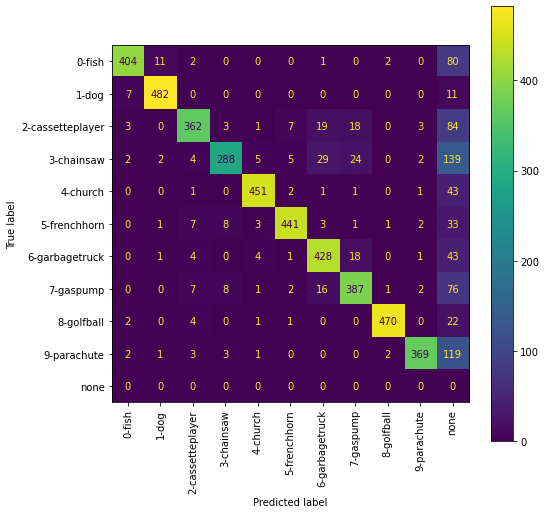

In [13]:
# create "img_answer" column for confusion matrix
# Imagenette Classes
conf_classes = ['0-fish', 
                '1-dog', 
                '2-cassetteplayer', 
                '3-chainsaw',
                '4-church', 
                '5-frenchhorn', 
                '6-garbagetruck', 
                '7-gaspump', 
                '8-golfball', 
                '9-parachute',
                'none']

for label in conf_classes:
    exp2.loc[exp2['Answer.classes.{}'.format(label)] == True, 'img_answer'] = label

# Create Confusion Matrix
cmatrix = confusion_matrix(exp2['img_class'], exp2['img_answer'], labels=conf_classes)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=conf_classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(xticks_rotation='vertical', ax=ax)

In [14]:
# Interannotator Agreement
simpledorff.calculate_krippendorffs_alpha_for_df(exp2,
                                                 experiment_col='Input.image_url',
                                                 annotator_col='WorkerId',
                                                 class_col='img_answer')

0.7413709657056397

In [ ]:
# Img IDs where Turkers agree least often (maximum 15)
exp2.loc[exp2['img_id'].apply(lambda x: len(exp2.loc[(exp2['img_id']==x) & (exp2['img_class']==exp2['img_answer'])])) <= 5]['img_id'].unique()

In [15]:
# Total of 5000 answers
len(exp2)

5000

In [16]:
# Check if every class was answered 500 times
exp2['img_class'].value_counts()

6-garbagetruck      500
3-chainsaw          500
9-parachute         500
2-cassetteplayer    500
0-fish              500
4-church            500
1-dog               500
8-golfball          500
5-frenchhorn        500
7-gaspump           500
Name: img_class, dtype: int64

In [17]:
# How often not identifiable whats on the image?
exp2['Answer.classes.none'].value_counts()

False    4350
True      650
Name: Answer.classes.none, dtype: int64

In [18]:
# Total correct
len(exp2.loc[(exp2['correct'] == 1)]), len(exp2.loc[(exp2['correct'] == 1)]) / len(exp2)

(4082, 0.8164)

In [19]:
# Total wrong
len(exp2.loc[(exp2['correct'] == 0)]), len(exp2.loc[(exp2['correct'] == 0)]) / len(exp2)

(918, 0.1836)

In [ ]:
#######################
# Chisquare: Whether correct results are significant:
# correct for 2pruned, 32pruned - expected: as much correct as in nonpruned
#chisquare([2160, 2033], [2146, 2146]), chisquare([2160, 2033, 2146], [2146, 2146, 2146])

## Overall: Correct per Class and per Models

In [20]:
# Overview of how many correct per class for all three models, maximum = 500 per class
exp2['img_class'].loc[(exp2['correct'] == 1)].value_counts() / 500

1-dog               0.964
8-golfball          0.940
4-church            0.902
5-frenchhorn        0.882
6-garbagetruck      0.856
0-fish              0.808
7-gaspump           0.774
9-parachute         0.738
2-cassetteplayer    0.724
3-chainsaw          0.576
Name: img_class, dtype: float64

In [21]:
# Overview of how many correct per model, per model maximum = 2500; total 5000
exp2['algorithm'].loc[(exp2['correct'] == 1)].value_counts()

4pruned    2052
8pruned    2030
Name: algorithm, dtype: int64

In [22]:
# For each class, how many corrects differ between models:
for label in classes:
    print(label)
    print(exp2['algorithm'].loc[(exp2['correct'] == 1) & (exp2['img_class'] == label)].value_counts())

0-fish
4pruned    210
8pruned    194
Name: algorithm, dtype: int64
1-dog
8pruned    243
4pruned    239
Name: algorithm, dtype: int64
2-cassetteplayer
4pruned    183
8pruned    179
Name: algorithm, dtype: int64
3-chainsaw
4pruned    147
8pruned    141
Name: algorithm, dtype: int64
4-church
4pruned    227
8pruned    224
Name: algorithm, dtype: int64
5-frenchhorn
8pruned    224
4pruned    217
Name: algorithm, dtype: int64
6-garbagetruck
4pruned    216
8pruned    212
Name: algorithm, dtype: int64
7-gaspump
4pruned    194
8pruned    193
Name: algorithm, dtype: int64
8-golfball
4pruned    241
8pruned    229
Name: algorithm, dtype: int64
9-parachute
8pruned    191
4pruned    178
Name: algorithm, dtype: int64


In [ ]:
exp2.loc[(exp2['Answer.classes.1-dog'] == True) &
        (exp2['algorithm'] == '32pruned')] \
    .groupby(['img_id']) \
    .aggregate('count') \
    .sort_values(by='HITId', ascending=False)

## 4-pruned

In [23]:
exp2_4p = exp2.loc[exp2['algorithm'] == '4pruned']
len(exp2_4p)

2500

In [ ]:
# Img IDs where Turkers agree least often (maximum 5)
exp2_4p.loc[exp2_4p['img_id'].apply(lambda x: len(exp2_4p.loc[(exp2_4p['img_id']==x) & (exp2_4p['img_class'] == exp2_4p['img_answer'])])) <= 2]['img_id'].unique()

In [24]:
# Total correct
len(exp2_4p.loc[(exp2_4p['correct'] == 1)]), len(exp2_4p.loc[(exp2_4p['correct'] == 1)]) / len(exp2_4p)

(2052, 0.8208)

In [25]:
# How often not identifiable whats on the image?
exp2_4p['Answer.classes.none'].value_counts()

False    2186
True      314
Name: Answer.classes.none, dtype: int64

In [28]:
# Correct answers for 4pruned, splitted by every class, maximum 250 per class
exp2_4p['img_class'].loc[(exp2_4p['correct'] == 1)].value_counts() / 250

8-golfball          0.964
1-dog               0.956
4-church            0.908
5-frenchhorn        0.868
6-garbagetruck      0.864
0-fish              0.840
7-gaspump           0.776
2-cassetteplayer    0.732
9-parachute         0.712
3-chainsaw          0.588
Name: img_class, dtype: float64

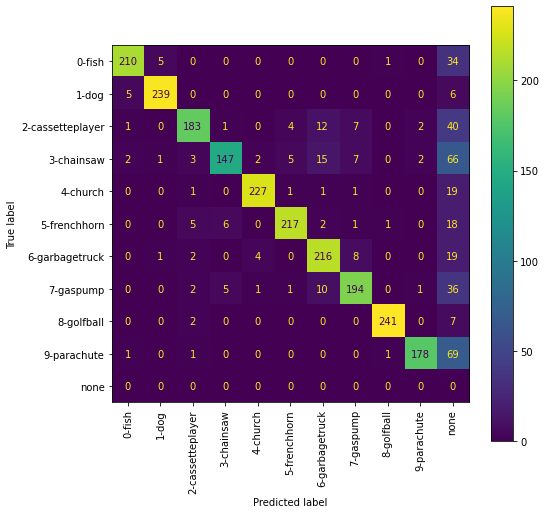

In [29]:
# Create Confusion Matrix
cmatrix = confusion_matrix(exp2_4p['img_class'], exp2_4p['img_answer'], labels=conf_classes)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=conf_classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(xticks_rotation='vertical', ax=ax)

## 8-Pruned

In [30]:
exp2_8p = exp2.loc[exp2['algorithm'] == '8pruned']
len(exp2_8p)

2500

In [ ]:
# Img IDs where Turkers agree least often (maximum 5)
exp2_8p.loc[exp2_8p['img_id'].apply(lambda x: len(exp2_8p.loc[(exp2_8p['img_id']==x) & (exp2_8p['img_class'] == exp2_8p['img_answer'])])) <= 2]['img_id'].unique()

In [31]:
# Total correct
len(exp2_8p.loc[(exp2_8p['correct'] == 1)]), len(exp2_8p.loc[(exp2_8p['correct'] == 1)]) / len(exp2_8p)

(2030, 0.812)

In [32]:
# How often not identifiable whats on the image?
exp2_8p['Answer.classes.none'].value_counts()

False    2164
True      336
Name: Answer.classes.none, dtype: int64

In [33]:
# Correct answers for 8pruned, splitted by every class, maximum 250 per class
exp2_8p['img_class'].loc[(exp2_8p['correct'] == 1)].value_counts() / 250

1-dog               0.972
8-golfball          0.916
4-church            0.896
5-frenchhorn        0.896
6-garbagetruck      0.848
0-fish              0.776
7-gaspump           0.772
9-parachute         0.764
2-cassetteplayer    0.716
3-chainsaw          0.564
Name: img_class, dtype: float64

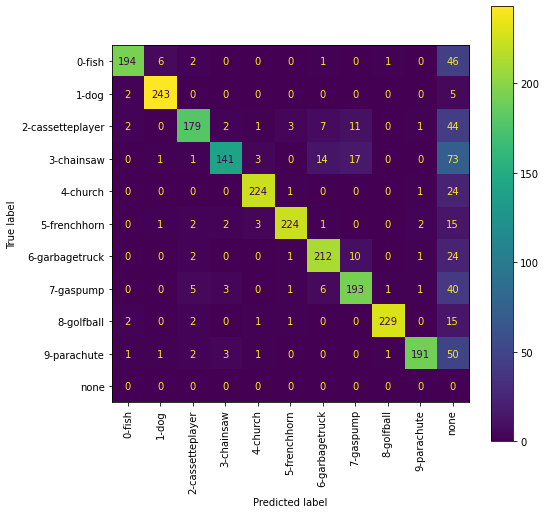

In [35]:
# Create Confusion Matrix
cmatrix = confusion_matrix(exp2_8p['img_class'], exp2_8p['img_answer'], labels=conf_classes)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=conf_classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(xticks_rotation='vertical', ax=ax)